# Tutorial 9: Cell type classification

In [ ]:
from cellplm import 

In [ ]:
parser = ArgumentParser(description="CellPLM for Cell Annotation")

parser.add_argument('--pretrain_version', type=str, default='20230926_85M')
parser.add_argument('--pretrain_directory', type=str, default='/media/dang/Omics/data/ckpts/CellPLM')
# 数据和环境
parser.add_argument('--dataset_name', type=str, required=True)
parser.add_argument('--dataset_name2', type=str, default=None)
parser.add_argument('--fold', type=str, default='fold_1')
parser.add_argument('--data_pct', type=int, required=True)
parser.add_argument('--seed', type=int, default=42)
parser.add_argument('--label_type', type=str, default='class', choices=['class', 'subclass'])

# 日志和保存
parser.add_argument('--evaluation_dir', type=str, default='./cellplm_evaluation')
parser.add_argument('--save_detailed_reports', type=bool, required=True)
parser.add_argument('--save_anndata', type=bool, required=True)
parser.add_argument('--compute_gene_level_metrics', type=bool, required=True)

# 模式控制
parser.add_argument('--mode', type=str, default='test', choices=['test', 'train_test'])

# Fusion相关参数
parser.add_argument('--enable_fusion', type=bool, default=True)
parser.add_argument('--fusion_type', type=str, default='concat', choices=['concat', 'add', 'gated', 'attention'])
parser.add_argument('--fusion_dropout', type=float, default=0.2)

args = parser.parse_args()

if args.dataset_name == 'mop1_filtered':
    data_path = f'/media/dang/Omics/omics/baseline/imputation/cell_embeddings_with_GT/processed_adata_mop1_filtered_42_{args.data_pct}.h5ad'
    data_path2 = None
else:
    data_path = f'/media/dang/Omics/omics/baseline/annotation/cell_embeddings_with_GT/processed_adata_{args.dataset_name}_{args.seed}_{args.data_pct}.h5ad'
    data_path2 = f'/media/dang/Omics/omics/baseline/annotation/cell_embeddings_with_GT/processed_adata_{args.dataset_name2}_{args.seed}_{args.data_pct}.h5ad'
# import ipdb; ipdb.set_trace()
# load downstream dataset
data = load_data(data_path, data_path2, args.label_type, args.fold, args.seed)

# overwrite parts of the default config
pipeline_config = CellTypeAnnotationDefaultPipelineConfig.copy()

model_config = CellTypeAnnotationDefaultModelConfig.copy()
model_config['out_dim'] = data.obs['celltype'].nunique()

# import ipdb; ipdb.set_trace()

# fine-tuning the model (冻住encoder, 只训练decoder)

pipeline_config = CellTypeAnnotationDefaultPipelineConfig.copy()

model_config = CellTypeAnnotationDefaultModelConfig.copy()
model_config['out_dim'] = data.obs['celltype'].nunique()
pipeline_config, model_config

model_config['enable_cell_embedding'] = True
model_config['post_latent_dim'] = 768
model_config['enable_fusion'] = args.enable_fusion
model_config['fusion_type'] = args.fusion_type
model_config['fusion_dropout'] = args.fusion_dropout
# model_config['enc_hid'] = data.X.shape[1]
model_config['enc_hid'] = 217 if args.dataset_name == 'mop1_filtered' else 1000

pipeline = CellTypeAnnotationPipeline(pretrain_prefix=args.pretrain_version, # Specify the pretrain checkpoint to load
                                    overwrite_config=model_config,  # This is for overwriting part of the pretrain config
                                    pretrain_directory=args.pretrain_directory)
pipeline.model

if args.mode == 'train_test':
    pipeline.fit(data, # An AnnData object
            pipeline_config, # The config dictionary we created previously, optional
            split_field = 'split', #  Specify a column in .obs that contains split information
            train_split = 'train',
            valid_split = 'valid',
            label_fields = ['celltype'], # Specify a column in .obs that contains cell type labels
            enable_fusion = args.enable_fusion) # 启用fusion功能

# inference and evaluation
if args.mode == 'test':
    pipeline.fitted = True # 虽然它不support not fitted, 但是可以强行设置为True, 反正checkpoint都load了

pipeline.predict(
                data, # An AnnData object
                pipeline_config, # The config dictionary we created previously, optional
                label_fields = ['celltype'],
                enable_fusion = args.enable_fusion # 启用fusion功能
            )

scores = pipeline.score(data, # An AnnData object
            pipeline_config, # The config dictionary we created previously, optional
            split_field = 'split', # Specify a column in .obs to specify train and valid split, optional
            target_split = 'test', # Specify a target split to predict, optional
            label_fields = ['celltype'],# Specify a column in .obs that contains cell type labels
            dataset_name = args.dataset_name,
            fold_name = args.fold,
            data_pct = args.data_pct,
            seed = args.seed,
            label_type = args.label_type,
            evaluation_output_dir = args.evaluation_dir,
            save_detailed_reports = args.save_detailed_reports,
            save_anndata = args.save_anndata)  

print(scores)

# Result visualization

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

import scipy.stats as stats
import mpl_toolkits.axisartist as axisartist

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import scanpy as sc
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
baseline_path = "/media/dang/Omics/omics/baseline/annotation/cellplm_evaluation/cellPLM_mop1_filtered_fold_1_42_20250819_215447_50_subclass.h5ad"
enhanced_path = "/media/dang/Omics/omics/baseline/annotation/cellplm_enhanced_evaluation/cellPLM_mop1_filtered_fold_1_42_20250825_000654_50_subclass.h5ad"

In [ ]:
adata = sc.read_h5ad(baseline_path)

adata

AnnData object with n_obs × n_vars = 5910 × 217
    obs: 'cell_id', 'center_x', 'center_y', 'n_detected_spots', 'n_detected_genes', 'batch', 'slice_id', 'fold_1_assignment', 'fold_2_assignment', 'fold_3_assignment', 'fold_4_assignment', 'fold_5_assignment', 'n_total_spots', 'n_total_genes', 'class_label', 'subclass', 'label', 'split', 'celltype', 'ground_truth_cell_type', 'cellPLM_predicted', 'prediction_correct', 'used_for_annotation', 'fold_used', 'method_used', 'evaluation_seed', 'cellPLM_confidence', 'cellPLM_entropy', 'cellPLM_Astro', 'cellPLM_Endo', 'cellPLM_L2/3_IT', 'cellPLM_L4/5_IT', 'cellPLM_L5_ET', 'cellPLM_L5_IT', 'cellPLM_L5/6_NP', 'cellPLM_L6_CT', 'cellPLM_L6_IT', 'cellPLM_L6_IT_Car3', 'cellPLM_L6b', 'cellPLM_Lamp5', 'cellPLM_Micro', 'cellPLM_OPC', 'cellPLM_Oligo', 'cellPLM_PVM', 'cellPLM_Peri', 'cellPLM_Pvalb', 'cellPLM_SMC', 'cellPLM_Sncg', 'cellPLM_Sst', 'cellPLM_Unknown', 'cellPLM_VLMC', 'cellPLM_Vip', 'ground_truth_cell_type_name', 'cellPLM_predicted_name'
    uns: '

In [ ]:
enc_adata = sc.read_h5ad(enhanced_path)

enc_adata

AnnData object with n_obs × n_vars = 5910 × 217
    obs: 'cell_id', 'center_x', 'center_y', 'n_detected_spots', 'n_detected_genes', 'batch', 'slice_id', 'fold_1_assignment', 'fold_2_assignment', 'fold_3_assignment', 'fold_4_assignment', 'fold_5_assignment', 'n_total_spots', 'n_total_genes', 'class_label', 'subclass', 'label', 'split', 'celltype', 'ground_truth_cell_type', 'cellPLM_predicted', 'prediction_correct', 'used_for_annotation', 'fold_used', 'method_used', 'evaluation_seed', 'cellPLM_confidence', 'cellPLM_entropy', 'cellPLM_Astro', 'cellPLM_Endo', 'cellPLM_L2/3_IT', 'cellPLM_L4/5_IT', 'cellPLM_L5_ET', 'cellPLM_L5_IT', 'cellPLM_L5/6_NP', 'cellPLM_L6_CT', 'cellPLM_L6_IT', 'cellPLM_L6_IT_Car3', 'cellPLM_L6b', 'cellPLM_Lamp5', 'cellPLM_Micro', 'cellPLM_OPC', 'cellPLM_Oligo', 'cellPLM_PVM', 'cellPLM_Peri', 'cellPLM_Pvalb', 'cellPLM_SMC', 'cellPLM_Sncg', 'cellPLM_Sst', 'cellPLM_Unknown', 'cellPLM_VLMC', 'cellPLM_Vip', 'ground_truth_cell_type_name', 'cellPLM_predicted_name'
    uns: '

# 计算AUC

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def load_data_from_h5ad(h5ad_path):
    """从h5ad文件加载评估数据"""
    print(f"📂 Loading data from: {h5ad_path}")
    
    adata = sc.read_h5ad(h5ad_path)
    
    # 查找概率矩阵
    prob_keys = [key for key in adata.obsm.keys() if 'probabilities' in key]
    if len(prob_keys) == 0:
        print("⚠️ No probability matrices found in obsm")
        return None, None, None, None
    
    prob_key = prob_keys[0]
    probabilities = adata.obsm[prob_key]
    method_name = prob_key.replace('_probabilities', '')
    
    # 获取类别名称
    col_key = f"{method_name}_probability_columns"
    if col_key in adata.uns:
        class_names = adata.uns[col_key]
    else:
        class_names = [f"Class_{i}" for i in range(probabilities.shape[1])]
    
    # 直接使用字符串类型的标签
    pred_col = f"{method_name}_predicted_name"
    gt_col = "ground_truth_cell_type_name"
    
    if pred_col not in adata.obs.columns:
        pred_col = f"{method_name}_predicted"
    
    if gt_col not in adata.obs.columns:
        gt_col = "ground_truth_cell_type"
    
    if pred_col not in adata.obs.columns or gt_col not in adata.obs.columns:
        print(f"⚠️ Could not find prediction/ground truth columns")
        return None, None, None, None
    
    ground_truth = adata.obs[gt_col].values
    
    # 只过滤ground truth为Unknown的样本
    gt_unknown_mask = ground_truth != "Unknown"
    ground_truth_filtered = ground_truth[gt_unknown_mask]
    probabilities_filtered = probabilities[gt_unknown_mask]
    
    # 从类别列表中移除Unknown
    class_names_no_unknown = [cls for cls in class_names if cls != "Unknown"]
    
    # 如果有Unknown列，从概率矩阵中移除对应的列
    if col_key in adata.uns:
        original_class_names = adata.uns[col_key]
        if "Unknown" in original_class_names:
            unknown_idx = list(original_class_names).index("Unknown")
            probabilities_filtered = np.delete(probabilities_filtered, unknown_idx, axis=1)
    
    print(f"After filtering: {len(ground_truth_filtered)} cells, {len(class_names_no_unknown)} classes")
    
    return probabilities_filtered, ground_truth_filtered, class_names_no_unknown, method_name

def calculate_per_class_auc(probabilities, ground_truth, class_names):
    """
    计算每个细胞类型的AUC (One-vs-Rest)
    
    Parameters:
    -----------
    probabilities : np.ndarray
        预测概率矩阵 (n_samples, n_classes)
    ground_truth : np.ndarray
        真实标签 (n_samples,)
    class_names : list
        类别名称列表
    
    Returns:
    --------
    auc_dict : dict
        每个类别的AUC值
    auc_details : dict
        详细信息
    """
    print("\n" + "="*60)
    print("📊 计算每个细胞类型的AUC...")
    
    # 将标签二值化（One-vs-Rest）
    y_true_binarized = label_binarize(ground_truth, classes=class_names)
    
    # 如果只有两个类别，label_binarize会返回(n_samples, 1)，需要扩展
    if y_true_binarized.shape[1] == 1:
        y_true_binarized = np.hstack([1 - y_true_binarized, y_true_binarized])
    
    auc_dict = {}
    auc_details = {}
    
    for i, class_name in enumerate(class_names):
        try:
            # 计算该类别的样本数
            n_positive = np.sum(ground_truth == class_name)
            n_negative = len(ground_truth) - n_positive
            
            if n_positive == 0 or n_negative == 0:
                print(f"  ⚠️ {class_name}: 跳过 (只有一个类别的样本)")
                auc_dict[class_name] = np.nan
                continue
            
            # 计算AUC
            auc = roc_auc_score(y_true_binarized[:, i], probabilities[:, i])
            auc_dict[class_name] = auc
            
            # 保存详细信息
            auc_details[class_name] = {
                'auc': auc,
                'n_positive': n_positive,
                'n_negative': n_negative,
                'proportion': n_positive / len(ground_truth)
            }
            
            print(f"  ✅ {class_name}: AUC={auc:.4f} (n={n_positive}, {n_positive/len(ground_truth):.2%})")
            
        except Exception as e:
            print(f"  ❌ {class_name}: 计算失败 - {str(e)}")
            auc_dict[class_name] = np.nan
    
    # 计算宏平均AUC（忽略NaN值）
    valid_aucs = [v for v in auc_dict.values() if not np.isnan(v)]
    if valid_aucs:
        macro_auc = np.mean(valid_aucs)
        print(f"\n  📈 宏平均AUC (Macro-average): {macro_auc:.4f}")
    
    return auc_dict, auc_details

def save_auc_to_csv(baseline_auc, enhanced_auc, baseline_details, enhanced_details, filename="auc_results.csv"):
    """
    将AUC结果保存为CSV文件
    
    Parameters:
    -----------
    baseline_auc : dict
        Baseline方法的AUC字典
    enhanced_auc : dict
        Enhanced方法的AUC字典
    baseline_details : dict
        Baseline的详细信息
    enhanced_details : dict
        Enhanced的详细信息
    filename : str
        输出CSV文件名
    """
    print("\n" + "="*60)
    print("💾 保存AUC结果到CSV...")
    
    # 准备数据
    results = []
    all_classes = set(list(baseline_auc.keys()) + list(enhanced_auc.keys()))
    
    for class_name in sorted(all_classes):
        baseline_val = baseline_auc.get(class_name, np.nan)
        enhanced_val = enhanced_auc.get(class_name, np.nan)
        
        # 获取样本数量信息
        n_samples_baseline = baseline_details.get(class_name, {}).get('n_positive', 0)
        n_samples_enhanced = enhanced_details.get(class_name, {}).get('n_positive', 0)
        
        # 计算改进
        if not np.isnan(baseline_val) and not np.isnan(enhanced_val):
            improvement = enhanced_val - baseline_val
            improvement_pct = (improvement / baseline_val) * 100 if baseline_val > 0 else np.nan
        else:
            improvement = np.nan
            improvement_pct = np.nan
        
        results.append({
            'Cell Type': class_name,
            'Baseline AUC': baseline_val,
            'Enhanced AUC': enhanced_val,
            'Improvement (Δ)': improvement,
            'Improvement (%)': improvement_pct,
            'N Samples': n_samples_baseline
        })
    
    df_results = pd.DataFrame(results)
    
    # 按Baseline AUC降序排序
    df_results = df_results.sort_values('Baseline AUC', ascending=False)
    
    # 保存到CSV
    df_results.to_csv(filename, index=False, float_format='%.6f')
    print(f"✅ AUC结果已保存到: {filename}")
    
    # 打印摘要统计
    print("\n📊 AUC统计摘要:")
    valid_improvements = df_results['Improvement (Δ)'].dropna()
    if len(valid_improvements) > 0:
        print(f"  平均改进: {valid_improvements.mean():.6f}")
        print(f"  中位数改进: {valid_improvements.median():.6f}")
        print(f"  改进的类别数: {(valid_improvements > 0).sum()}/{len(valid_improvements)}")
    
    return df_results

def calculate_auc_comparison(baseline_h5ad_path, enhanced_h5ad_path):
    """计算并比较Baseline和Enhanced的AUC"""
    
    # 加载数据
    baseline_data = load_data_from_h5ad(baseline_h5ad_path)
    enhanced_data = load_data_from_h5ad(enhanced_h5ad_path)
    
    if baseline_data[0] is None or enhanced_data[0] is None:
        print("❌ Failed to load data from h5ad files")
        return None
    
    baseline_probs, baseline_gt, class_names, baseline_method = baseline_data
    enhanced_probs, enhanced_gt, _, enhanced_method = enhanced_data
    
    print(f"\n📊 数据统计:")
    print(f"Baseline方法: {baseline_method}")
    print(f"Enhanced方法: {enhanced_method}")
    print(f"细胞数: {len(baseline_gt)}")
    print(f"类别数: {len(class_names)}")
    
    # 计算每个细胞类型的AUC
    print("\n" + "="*60)
    print("📊 计算Baseline的AUC...")
    baseline_auc, baseline_details = calculate_per_class_auc(baseline_probs, baseline_gt, class_names)
    
    print("\n" + "="*60)
    print("📊 计算Enhanced的AUC...")
    enhanced_auc, enhanced_details = calculate_per_class_auc(enhanced_probs, enhanced_gt, class_names)
    
    # 保存AUC结果到CSV
    auc_df = save_auc_to_csv(baseline_auc, enhanced_auc, baseline_details, enhanced_details)
    
    return auc_df

# 使用示例
if __name__ == "__main__":
    baseline_path = "/media/dang/Omics/omics/baseline/annotation/cellplm_evaluation/cellPLM_mop1_filtered_fold_1_42_20250819_215447_50_subclass.h5ad"
    enhanced_path = "/media/dang/Omics/omics/baseline/annotation/cellplm_enhanced_evaluation/cellPLM_mop1_filtered_fold_1_42_20250825_000654_50_subclass.h5ad"
    
    print("🚀 开始计算AUC...")
    auc_df = calculate_auc_comparison(baseline_path, enhanced_path)
    
    print("\n✅ AUC计算完成！")
    print("📁 生成的文件: auc_results.csv")

🚀 开始计算AUC...
📂 Loading data from: /media/dang/Omics/omics/baseline/annotation/cellplm_evaluation/cellPLM_mop1_filtered_fold_1_42_20250819_215447_50_subclass.h5ad
After filtering: 4167 cells, 23 classes
📂 Loading data from: /media/dang/Omics/omics/baseline/annotation/cellplm_enhanced_evaluation/cellPLM_mop1_filtered_fold_1_42_20250825_000654_50_subclass.h5ad
After filtering: 4167 cells, 23 classes

📊 数据统计:
Baseline方法: cellPLM
Enhanced方法: cellPLM
细胞数: 4167
类别数: 23

📊 计算Baseline的AUC...

📊 计算每个细胞类型的AUC...
  ✅ Astro: AUC=0.9893 (n=257, 6.17%)
  ✅ Endo: AUC=0.9933 (n=321, 7.70%)
  ✅ L2/3 IT: AUC=0.9880 (n=798, 19.15%)
  ✅ L4/5 IT: AUC=0.9541 (n=548, 13.15%)
  ✅ L5 ET: AUC=0.9598 (n=201, 4.82%)
  ✅ L5 IT: AUC=0.8911 (n=341, 8.18%)
  ✅ L5/6 NP: AUC=0.9816 (n=93, 2.23%)
  ✅ L6 CT: AUC=0.9833 (n=306, 7.34%)
  ✅ L6 IT: AUC=0.8888 (n=223, 5.35%)
  ✅ L6 IT Car3: AUC=0.9114 (n=33, 0.79%)
  ✅ L6b: AUC=0.8868 (n=3, 0.07%)
  ✅ Lamp5: AUC=0.9911 (n=72, 1.73%)
  ✅ Micro: AUC=0.9469 (n=80, 1.92%)
  ✅ OPC:

# 绘图

🚀 开始生成单细胞置信度热力图 (使用seaborn模板)...
📂 Loading data from: /media/dang/Omics/omics/baseline/annotation/cellplm_evaluation/cellPLM_mop1_filtered_fold_1_42_20250819_215447_50_subclass.h5ad
After filtering: 4167 cells, 23 classes
📂 Loading data from: /media/dang/Omics/omics/baseline/annotation/cellplm_enhanced_evaluation/cellPLM_mop1_filtered_fold_1_42_20250825_000654_50_subclass.h5ad
After filtering: 4167 cells, 23 classes

📊 数据统计:
Baseline方法: cellPLM
Enhanced方法: cellPLM
细胞数: 4167
类别数: 23

🎨 生成Baseline单细胞置信度热力图...
🎨 Creating single-cell confidence heatmap: Baseline Single-Cell Confidence (cellPLM)
⚠️ 细胞数量(4167)过多，随机采样2000个细胞
📊 Classes sorted by sample count:
  L2/3 IT: 359 samples (17.9%)
  L4/5 IT: 264 samples (13.2%)
  L5 IT: 166 samples (8.3%)
  Endo: 156 samples (7.8%)
  L6 CT: 154 samples (7.7%)
  Astro: 127 samples (6.3%)
  L5 ET: 97 samples (4.9%)
  L6 IT: 96 samples (4.8%)
  VLMC: 70 samples (3.5%)
  Pvalb: 60 samples (3.0%)
  Peri: 59 samples (2.9%)
  Oligo: 56 samples (2.8%)
  L5/6 

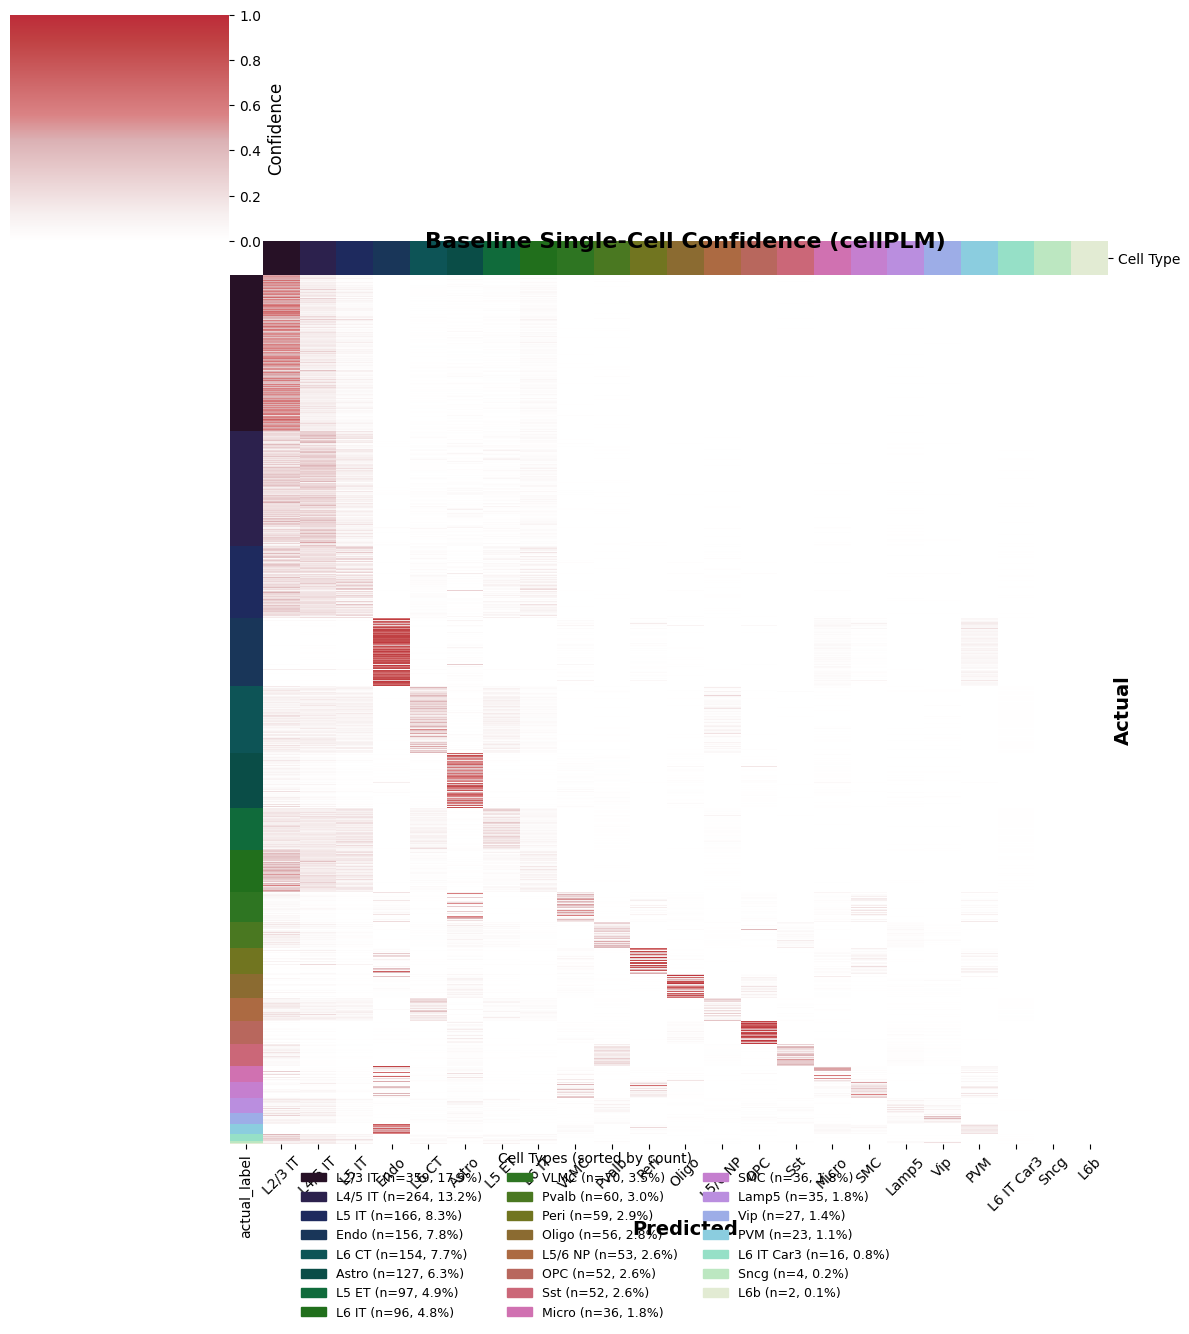


🎨 生成Enhanced单细胞置信度热力图...
🎨 Creating single-cell confidence heatmap: Enhanced Single-Cell Confidence (cellPLM)
⚠️ 细胞数量(4167)过多，随机采样2000个细胞
📊 Classes sorted by sample count:
  L2/3 IT: 359 samples (17.9%)
  L4/5 IT: 264 samples (13.2%)
  L5 IT: 166 samples (8.3%)
  Endo: 156 samples (7.8%)
  L6 CT: 154 samples (7.7%)
  Astro: 127 samples (6.3%)
  L5 ET: 97 samples (4.9%)
  L6 IT: 96 samples (4.8%)
  VLMC: 70 samples (3.5%)
  Pvalb: 60 samples (3.0%)
  Peri: 59 samples (2.9%)
  Oligo: 56 samples (2.8%)
  L5/6 NP: 53 samples (2.6%)
  OPC: 52 samples (2.6%)
  Sst: 52 samples (2.6%)
  Micro: 36 samples (1.8%)
  SMC: 36 samples (1.8%)
  Lamp5: 35 samples (1.8%)
  Vip: 27 samples (1.4%)
  PVM: 23 samples (1.1%)
  L6 IT Car3: 16 samples (0.8%)
  Sncg: 4 samples (0.2%)
  L6b: 2 samples (0.1%)
步骤1: 数据准备完成 - 2000个细胞, 23个类别
步骤2: 正在根据真实标签排序...
数据排序完成。
步骤3: 正在创建注释颜色...
注释颜色创建完成。
步骤4: 正在使用clustermap绘制图表...
✅ 单细胞置信度热力图已保存: enhanced_single_cell_confidence_seaborn.pdf


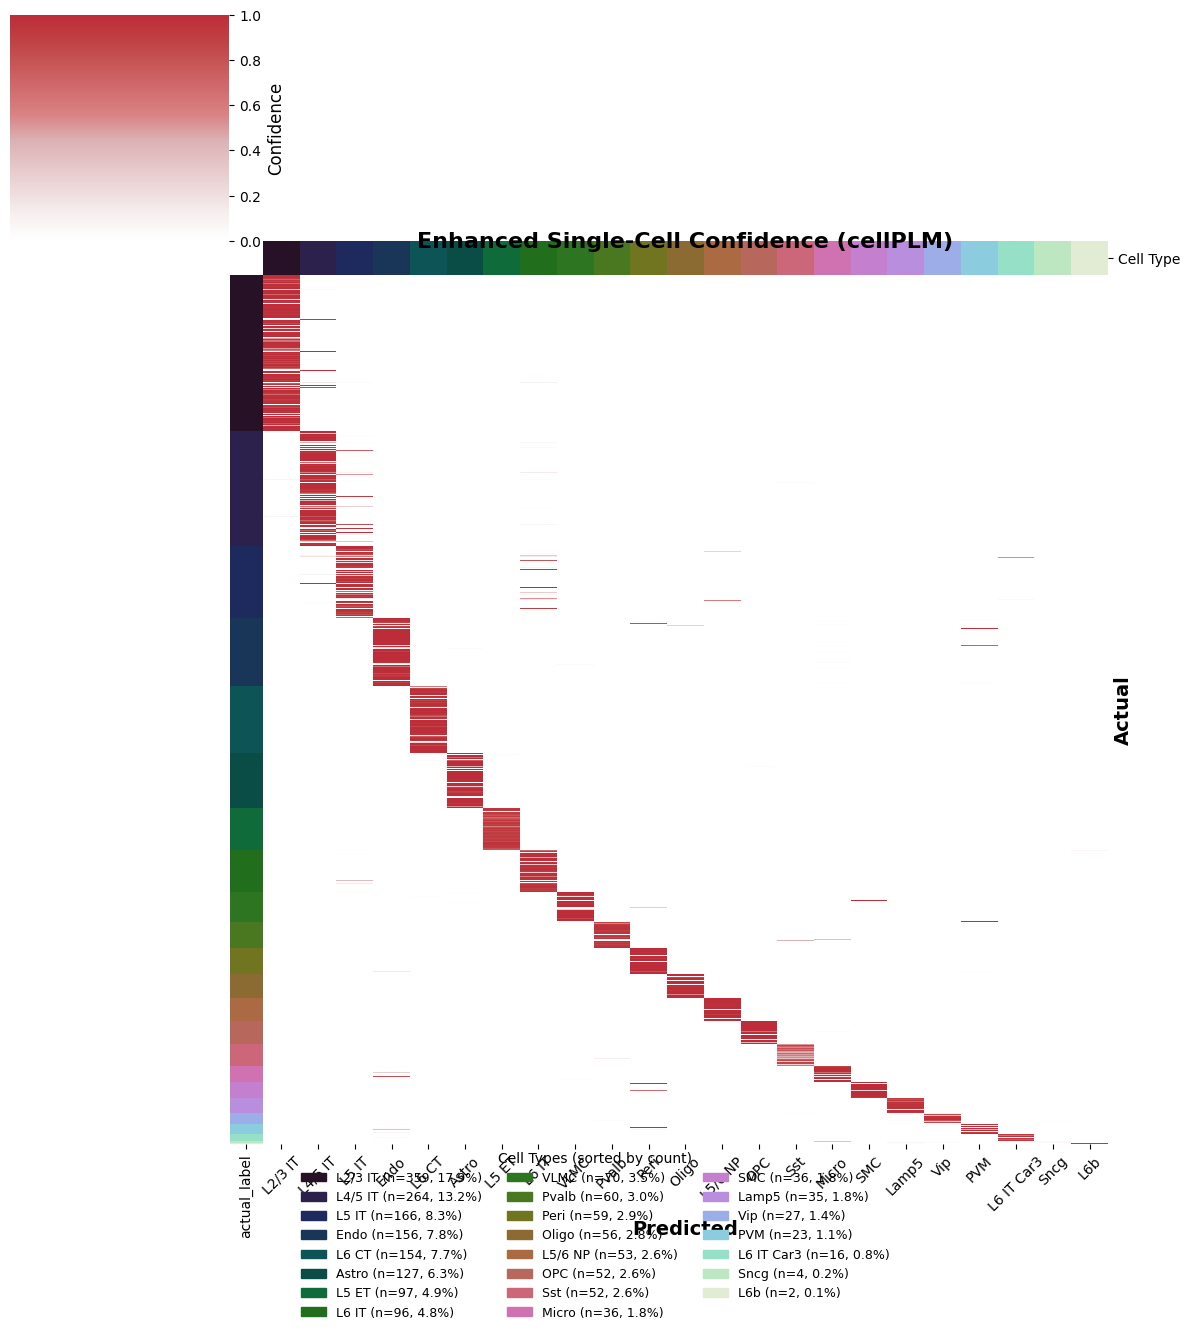


📊 性能对比:
平均最高置信度: Baseline 0.4013 → Enhanced 0.8334

✅ 所有单细胞置信度热力图生成完成！


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import scanpy as sc
from matplotlib.colors import LinearSegmentedColormap

def load_data_from_h5ad(h5ad_path):
    """从h5ad文件加载评估数据"""
    print(f"📂 Loading data from: {h5ad_path}")
    
    adata = sc.read_h5ad(h5ad_path)
    
    # 查找概率矩阵
    prob_keys = [key for key in adata.obsm.keys() if 'probabilities' in key]
    if len(prob_keys) == 0:
        print("⚠️ No probability matrices found in obsm")
        return None, None, None, None, None
    
    prob_key = prob_keys[0]
    probabilities = adata.obsm[prob_key]
    method_name = prob_key.replace('_probabilities', '')
    
    # 获取类别名称
    col_key = f"{method_name}_probability_columns"
    if col_key in adata.uns:
        class_names = adata.uns[col_key]
    else:
        class_names = [f"Class_{i}" for i in range(probabilities.shape[1])]
    
    # 直接使用字符串类型的标签
    pred_col = f"{method_name}_predicted_name"
    gt_col = "ground_truth_cell_type_name"
    
    if pred_col not in adata.obs.columns:
        pred_col = f"{method_name}_predicted"
    
    if gt_col not in adata.obs.columns:
        gt_col = "ground_truth_cell_type"
    
    if pred_col not in adata.obs.columns or gt_col not in adata.obs.columns:
        print(f"⚠️ Could not find prediction/ground truth columns")
        return None, None, None, None, None
    
    predictions = adata.obs[pred_col].values
    ground_truth = adata.obs[gt_col].values
    
    # 只过滤ground truth为Unknown的样本
    gt_unknown_mask = ground_truth != "Unknown"
    ground_truth_filtered = ground_truth[gt_unknown_mask]
    predictions_filtered = predictions[gt_unknown_mask]
    probabilities_filtered = probabilities[gt_unknown_mask]
    
    # 从类别列表中移除Unknown
    class_names_no_unknown = [cls for cls in class_names if cls != "Unknown"]
    
    # 如果有Unknown列，从概率矩阵中移除对应的列
    if col_key in adata.uns:
        original_class_names = adata.uns[col_key]
        if "Unknown" in original_class_names:
            unknown_idx = list(original_class_names).index("Unknown")
            probabilities_filtered = np.delete(probabilities_filtered, unknown_idx, axis=1)
    
    print(f"After filtering: {len(ground_truth_filtered)} cells, {len(class_names_no_unknown)} classes")
    
    return probabilities_filtered, predictions_filtered, ground_truth_filtered, class_names_no_unknown, method_name

def create_rainbow_cell_type_colors_sorted(sorted_classes):
    """创建彩虹色卡"""
    rainbow_colors = [
        '#271126',  # 深紫
        '#2C214D',  # 紫
        '#1E2A5E',  # 紫蓝过渡
        '#193659',  # 深蓝
        '#0D5456',  # 青绿
        '#0A4D47',  # 青绿深化
        '#106B3B',  # 深绿
        '#216F1C',  # 绿
        '#2E7522',  # 黄绿
        '#4A7821',  # 黄绿深化
        '#717520',  # 橄榄绿
        '#8B6B31',  # 橄榄棕过渡
        '#AC6A42',  # 棕
        '#B8675D',  # 棕粉过渡色
        '#CB6778',  # 粉红
        '#D071B1',  # 洋红
        '#C57FCF',  # 洋红淡紫过渡
        '#BA8EDF',  # 淡紫
        '#9DADE7',  # 淡蓝
        '#8BCDDF',  # 天蓝
        '#96E0C7',  # 薄荷绿
        '#BCE7C1',  # 淡绿
        '#E2EBD3'   # 淡黄绿
    ]
    
    colors = []
    for i in range(len(sorted_classes)):
        colors.append(rainbow_colors[i % len(rainbow_colors)])
    
    return dict(zip(sorted_classes, colors))

def create_custom_colormap():
    """创建白色到红色的配色方案"""
    colors = [
        '#ffffff',  # 白色
        '#f7f0f0',  # 很浅灰粉
        '#eedbdc',  # 浅灰粉
        '#e5c6c8',  # 浅粉
        '#dbb1b4',  # 粉色
        '#DA8385',  # 中间色
        '#d16d6f',  # 深粉红
        '#c85759',  # 橙红过渡
        '#c04143',  # 红色过渡
        '#BD2C39'   # 目标红色
    ]
    return LinearSegmentedColormap.from_list("white_to_custom_red", colors, N=256)

def get_sorted_classes_by_count(ground_truth, class_names):
    """根据样本数量对类别进行排序（从多到少）"""
    unique_classes, class_counts = np.unique(ground_truth, return_counts=True)
    count_dict = dict(zip(unique_classes, class_counts))
    
    valid_classes = [cls for cls in class_names if cls in count_dict]
    sorted_classes = sorted(valid_classes, key=lambda x: count_dict[x], reverse=True)
    
    print("📊 Classes sorted by sample count:")
    for cls in sorted_classes:
        count = count_dict[cls]
        percentage = count / len(ground_truth) * 100
        print(f"  {cls}: {count} samples ({percentage:.1f}%)")
    
    return sorted_classes, count_dict

def create_single_cell_confidence_heatmap_seaborn(probabilities, ground_truth, class_names, title, filename, max_cells=2000):
    """🎯 使用你的seaborn模板创建单细胞置信度热力图"""
    
    print(f"🎨 Creating single-cell confidence heatmap: {title}")
    
    # --- 1. 数据准备和采样 ---
    n_cells = len(ground_truth)
    if n_cells > max_cells:
        print(f"⚠️ 细胞数量({n_cells})过多，随机采样{max_cells}个细胞")
        np.random.seed(42)
        sample_indices = np.random.choice(n_cells, max_cells, replace=False)
        probabilities = probabilities[sample_indices]
        ground_truth = ground_truth[sample_indices]
        n_cells = max_cells
    
    # 获取排序后的类别
    sorted_classes, count_dict = get_sorted_classes_by_count(ground_truth, class_names)
    
    # 重新排列概率矩阵的列（按照sorted_classes顺序）
    class_to_idx = {cls: i for i, cls in enumerate(class_names)}
    sorted_class_indices = [class_to_idx[cls] for cls in sorted_classes]
    probabilities_reordered = probabilities[:, sorted_class_indices]
    
    # 创建DataFrame
    confidence_df = pd.DataFrame(probabilities_reordered, columns=sorted_classes)
    
    print(f"步骤1: 数据准备完成 - {n_cells}个细胞, {len(sorted_classes)}个类别")
    
    # --- 2. 数据排序 ---
    print("步骤2: 正在根据真实标签排序...")
    
    # 创建排序DataFrame
    sorter_df = pd.DataFrame({
        "actual_label": ground_truth, 
        "original_index": np.arange(n_cells)
    })
    sorter_df["actual_label"] = pd.Categorical(
        sorter_df["actual_label"], categories=sorted_classes, ordered=True
    )
    
    # 按真实标签排序
    df_sorted = sorter_df.sort_values(by="actual_label")
    
    # 重新排列置信度矩阵的行
    sorted_confidence_df = confidence_df.iloc[df_sorted["original_index"]].reset_index(drop=True)
    sorted_true_labels = df_sorted["actual_label"].reset_index(drop=True)
    
    print("数据排序完成。")
    
    # --- 3. 创建注释颜色条 ---
    print("步骤3: 正在创建注释颜色...")
    
    # 使用我们的彩虹色卡
    cell_type_colors = create_rainbow_cell_type_colors_sorted(sorted_classes)
    
    # 创建行注释（Y轴）
    row_colors = sorted_true_labels.astype(str).map(cell_type_colors)
    
    # 创建列注释（X轴）
    col_map_series = pd.Series(sorted_classes, index=sorted_classes).map(cell_type_colors)
    col_colors_df = pd.DataFrame(col_map_series, columns=["Cell Type"])
    
    print("注释颜色创建完成。")
    
    # --- 4. 使用seaborn.clustermap绘图 ---
    print("步骤4: 正在使用clustermap绘制图表...")
    
    # 创建自定义色图
    custom_cmap = create_custom_colormap()
    
    g = sns.clustermap(
        sorted_confidence_df,  # 使用排序后的完整置信度矩阵
        cmap=custom_cmap,      # 使用我们的自定义色图
        center=None,           # 不设置中心值
        vmin=0, vmax=1,       # 设置值范围
        row_cluster=False,     # 关闭行聚类
        col_cluster=False,     # 关闭列聚类
        row_colors=row_colors,
        col_colors=col_colors_df,
        xticklabels=True,      # 显示X轴标签
        yticklabels=False,     # 不显示Y轴标签
        figsize=(12, max(8, n_cells//150)),  # 动态调整图形大小
        cbar_kws={"label": "Confidence"},
        cbar_pos=(0.02, 0.6, 0.015, 0.25),  # 调整色条位置
        rasterized=True,
    )
    
    # 设置轴标签
    g.ax_heatmap.set_xlabel("Predicted", fontsize=14, fontweight='bold')
    g.ax_heatmap.set_ylabel("Actual", fontsize=14, fontweight='bold')
    g.ax_heatmap.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # 旋转X轴标签
    g.ax_heatmap.tick_params(axis='x', rotation=45)
    
    # 调整色条
    g.ax_cbar.set_ylabel("Confidence", fontsize=12)
    g.ax_cbar.set_title("")
    
    # --- 5. 手动创建图例 ---
    legend_patches = []
    for class_name in sorted_classes:
        color = cell_type_colors[class_name]
        count = count_dict[class_name]
        proportion = count / len(sorted_true_labels)
        label = f"{class_name} (n={count}, {proportion:.1%})"
        legend_patches.append(Patch(color=color, label=label))
    
    # 计算图例列数
    ncol = min(3, len(sorted_classes))
    legend_ax = g.fig.add_axes([0.15, 0.01, 0.7, 0.08])
    legend_ax.legend(
        handles=legend_patches, 
        loc="center", 
        frameon=False, 
        ncol=ncol,
        fontsize=9,
        title="Cell Types (sorted by count)",
        title_fontsize=10
    )
    legend_ax.axis("off")
    
    # 调整整体布局
    g.fig.subplots_adjust(bottom=0.12)
    
    # 保存图片
    g.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ 单细胞置信度热力图已保存: {filename}")
    plt.show()
    
    return g.fig

def create_heatmaps_single_cell_confidence_seaborn(baseline_h5ad_path, enhanced_h5ad_path, max_cells=2000):
    """使用seaborn模板创建单细胞级别的置信度热力图"""
    
    # 加载数据
    baseline_data = load_data_from_h5ad(baseline_h5ad_path)
    enhanced_data = load_data_from_h5ad(enhanced_h5ad_path)
    
    if baseline_data[0] is None or enhanced_data[0] is None:
        print("❌ Failed to load data from h5ad files")
        return
    
    baseline_probs, baseline_preds, baseline_gt, class_names, baseline_method = baseline_data
    enhanced_probs, enhanced_preds, enhanced_gt, _, enhanced_method = enhanced_data
    
    print(f"\n📊 数据统计:")
    print(f"Baseline方法: {baseline_method}")
    print(f"Enhanced方法: {enhanced_method}")
    print(f"细胞数: {len(baseline_gt)}")
    print(f"类别数: {len(class_names)}")
    
    # 生成热力图
    print("\n" + "="*60)
    print("🎨 生成Baseline单细胞置信度热力图...")
    baseline_fig = create_single_cell_confidence_heatmap_seaborn(
        baseline_probs, baseline_gt, class_names,
        f"Baseline Single-Cell Confidence ({baseline_method})",
        "baseline_single_cell_confidence_seaborn.pdf",
        max_cells=max_cells
    )
    
    print("\n" + "="*60)
    print("🎨 生成Enhanced单细胞置信度热力图...")
    enhanced_fig = create_single_cell_confidence_heatmap_seaborn(
        enhanced_probs, enhanced_gt, class_names,
        f"Enhanced Single-Cell Confidence ({enhanced_method})",
        "enhanced_single_cell_confidence_seaborn.pdf",
        max_cells=max_cells
    )
    
    # 性能对比
    print("\n" + "="*60)
    print("📊 性能对比:")
    baseline_conf = np.mean(np.max(baseline_probs, axis=1))
    enhanced_conf = np.mean(np.max(enhanced_probs, axis=1))
    print(f"平均最高置信度: Baseline {baseline_conf:.4f} → Enhanced {enhanced_conf:.4f}")
    
    return baseline_fig, enhanced_fig

# 使用示例
if __name__ == "__main__":
    plt.rcParams.update({
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'legend.fontsize': 9,
        'figure.dpi': 100
    })
    
    baseline_path = "/media/dang/Omics/omics/baseline/annotation/cellplm_evaluation/cellPLM_mop1_filtered_fold_1_42_20250819_215447_50_subclass.h5ad"
    enhanced_path = "/media/dang/Omics/omics/baseline/annotation/cellplm_enhanced_evaluation/cellPLM_mop1_filtered_fold_1_42_20250825_000654_50_subclass.h5ad"
    
    print("🚀 开始生成单细胞置信度热力图 (使用seaborn模板)...")
    baseline_fig, enhanced_fig = create_heatmaps_single_cell_confidence_seaborn(
        baseline_path, enhanced_path, max_cells=2000
    )
    
    print("\n✅ 所有单细胞置信度热力图生成完成！")